# Chapter 24
# Taming Model Behavior with Regularization   



## Introduction  

In modern computation statistics and machine learning, we are often faced with a large number of independent variables, or features, which can be colinear or simply uninformative. Given the scale we need algorithms to reduce the number of independent variables to just the informative ones. Methods like stepwise selection are know to fail at scale as a result of the multiple hypothesis testing problem. Solution of this problem leads us to regularization and sparse models.

As a general rule, an overfit model has learned the training data too well. The overfitting likely involved learning noise present in the training data. This noise can arise from uninformative or weakly informative variables or features being used in the model. A related problem arises from using colinear independent variables or features. The colinarity confounds model training, amplifying random variation in the model fitting. Regardless of the source, the random noise causes the fitted model to exhibit high levels of random variation, or high variance.   When a new data case is presented to such a model it may produce unexpected results since the random noise will be different.    

To prevent overfitting, we seek to find **sparse models**. A sparse model uses just the most informative variables required to produce accurate outputs. Term sparse is used since uninformative variables are excluded from the model. Use of sparse models follows the principle of Occam's razor. In simple terms, Occam's razor is a scientific principle that the simplest of competing theories is preferred. A sparse model then is the simplest model that explains the behavior of the data.         

So, what is one to do to prevent overfitting of machine learning models? The most widely used set of tools for preventing overfitting are known as **regularization methods**. Regularization methods take a number of forms, but all have the same goal, to prevent overfitting of machine learning models. The sparse models resulting from the application of regularization methods will generalize better and be useful in production. 


## The Bias-Variance Trade-off

Regularization is not free, however. While regularization reduces the **variance** in the model results, it introduces **bias**. Whereas, an overfit model exhibits low bias the variance is high. The high variance leads to unpredictable results when the model is exposed to new data cases. On the other hand, the stronger the regularization of a model the lower the variance, but the greater the bias. This all means that when applying regularization you will need to contend with the **bias-variance trade-off**. 

To better understand the bias variance trade-off consider the following examples of extreme model cases:

- If the prediction for all cases is just the mean (or median), variance is minimized. The estimate for all cases is the same, so the bias of the estimates is zero. However, there is likely considerable variance in these estimates. 
- On the other hand, consider what happens when the data are fit with a kNN model with k=1. The training data will fit this model perfectly, since there is one model coefficient per training data point. The variance will be low. However, the model will have considerable bias when applied to test data. 

In either case, these extreme models will not generalize well and will exhibit large errors on any independent test data. Any practical model must come to terms with the trade-off between bias and variance to make accurate predictions. 

To better understand this trade-off you can consider the example of the mean square error, which can be decomposed into its components. The mean square error can be written as:

$$\Delta y^2 = E \Big[ \big(Y - \hat{f}(X) \big)^2 \Big] = \frac{1}{N} \sum_{i=1}^N \big(y_i - \hat{f}(x_i) \big)^2 $$

Where,
$Y = $ the label vector.  
$X = $ the feature matrix.   
$\hat{f}(x) = $ the trained model.   

Expanding the representation of the mean square error:

$$\Delta y^2 = \big( E[ \hat{f}(X)] - \hat{f}(X) \big)^2 + E \big[ ( \hat{f}(X) - E[ \hat{f}(X)])^2 \big] + \sigma^2\\
\Delta y^2 = Bias^2 + Variance + Irreducible\ Error$$

The forgoing looks a bit intimidating. How can we interpret this relationship?     

- The first term, $\Big( E[ \hat{f}(X)] - \hat{f}(X) \Big)^2$, is the expected value of the difference between the model output and the expected model output or the **bias** of the model. For a **unbiased model**, $E \Big[ \hat{f}(X)] - \hat{f}(X) \Big] = 0$. For example: an OLS model with $residuals \sim N(0, \sigma^2)$ is unbiased.        
- The second term, $E \Big[ \big( \hat{f}(X) - E[ \hat{f}(X)] \big)^2 \Big]$, is the expected squared difference between the model output and the expected model output, or the **variance** of the model. For a low variance model, $E \Big[ \big( \hat{f}(X) - E[ \hat{f}(X)] \big)^2 \Big] \rightarrow 0$. A low variance model generalizes since variance is low for each prediction, $\hat{f}(X)$.     
- Finally, $\sigma^2$ is inherent or irreducable error in data. We cannot do anything to improve this random variation.        

The relationship between bias and variance is illustrated in the figure below.

<img src="images/BiasVariance.png" alt="Drawing" style="width:600px; height:400px"/>
<center> Trade-off between bias and variance for machine learning model <center>      
    

Study this relationship. Notice that as regularization reduces variance, bias increases. The irreducible error will remain unchanged. Regularization parameters are chosen to minimize $\Delta x$. In many cases, this will prove challenging. 

## Load and Split the Dataset

With the above bit of theory in mind, it is time to try an example. In this example you will compute and compare linear regression models using different levels and types of regularization. 

Execute the code in the cell below to load the packages required for the rest of this notebook.

In [40]:
import pandas as pd
import numpy as np
import numpy.random as nr
import statsmodels.api as sm
import statsmodels.formula.api as smf  
import scipy.stats as ss
import patsy 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize, StandardScaler
import sklearn.metrics as sklm
from patsy import dmatrices
from sklearn import metrics
from math import sqrt

%matplotlib inline
sns.set(style='ticks', palette='Set2')

The code below does the following to load and prepare the data set:    
1. Load the data set.   
2. Scale the numeric columns except the columns used as labels for the examples. 
3. Split the 195 cases into 100 training cases and 95 test cases.   

In [41]:
## Load the data frame   
auto_data = pd.read_csv('AutoPricesClean.csv')

## Remove unwanted columns and scale numeric columns 
auto_data.drop(auto_data.columns[:3], axis=1, inplace=True)
numeric_columns = [col for col_type,col in zip(auto_data.iloc[:,:-3].dtypes,auto_data.iloc[:,:-3].columns) if col_type in ['int64','float64']]
auto_data.loc[:,numeric_columns] = StandardScaler().fit_transform(auto_data.loc[:,numeric_columns])

## Create a mask and use it to split the data into a train and test set   
nr.seed(6665)
mask = nr.choice(auto_data.index, size = 100, replace=False)
auto_data_train = auto_data.iloc[mask,:].reset_index()
auto_data_test = auto_data.drop(mask, axis=0).reset_index()

/var/folders/2x/j2yg_98j10n2xd364kzb8nvm0000gn/T/ipykernel_6402/2281575793.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.02101769 -0.02101769  0.50442456 -0.4241752   0.50633526 -0.09935635
  0.54454924  0.75472615  1.00693843 -0.31335465 -0.31335465  0.28851556
  0.39360402  0.94770675  1.2820791   1.56868396  1.80752135 -2.04635874
 -1.30882889 -1.24195442 -1.30500749 -1.30500749 -0.82351131 -1.13113387
 -1.08909849 -1.08909849 -0.70313727 -0.04585678  0.48149617 -1.61645144
 -1.41391734 -1.37952475 -1.18272274 -1.15215156 -1.04897381 -1.02222402
 -0.61715581 -0.51588876 -0.48722827 -0.35730073 -0.17960572 -0.50824596
 -0.4241752   0.33437234  2.87942355  2.87942355  2.65778245 -1.2782577
 -1.25915071 -1.24959721 -1.17316925 -1.16361575 -0.33246164 -0.28469417
 -0.33246164 -0.28469417 -0.2216411  -0.25603368  0.2120876   0.26940857
  1.82662834  2.27564263  1.78841436  2.31385661  2.25653564  2.15144719

In [42]:
mask = nr.choice(auto_data.index, size = 100, replace=False)
auto_data_train = auto_data.iloc[mask,:].reset_index()
auto_data_train.index

RangeIndex(start=0, stop=100, step=1)

## A first linear regression model

First you will create a model of city MPG using both categorical and real-valued features or independent variables and no regularization. In the terminology used before this model has high variance and low bias. In other words, this model is over-fit and provides a baseline for comparison with regularized models. 

### Dependency structure 

To get a feel for the relationship between the independent variables used in the model, we will compute and display a correlation matrix. A few notes about the code:    
1. We compute correlation using the design matrix. This approach is required, since the categorical variables must be one-hot encoded.    
2. The intercept term is not included in the design matrix. The intercept term is represented by a column of all 1a which has 0 variance, that therefore has undefined correlation coefficients.      

Execute the code and examine the results.

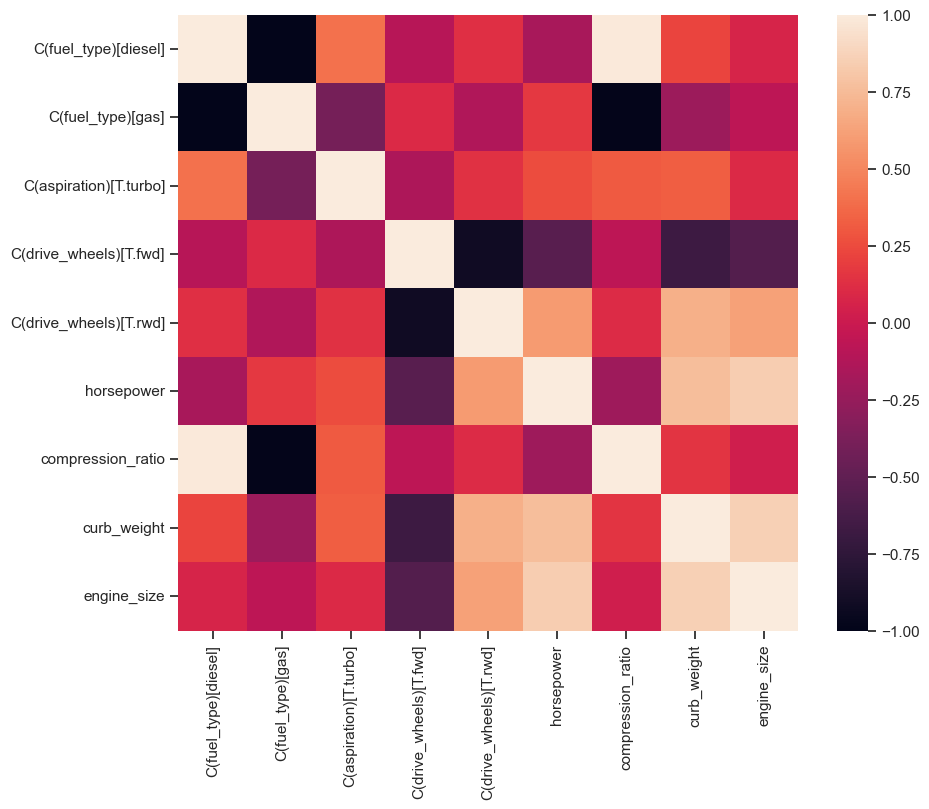

In [43]:
## Define model formula with no intercept - column of all 1s with 0 variance 
formula = 'city_mpg ~ -1 + C(fuel_type) + C(aspiration) + C(drive_wheels) + horsepower + compression_ratio + curb_weight + engine_size'

## Compute correlation matrix 
y, design_matrix = patsy.dmatrices(formula, data=auto_data)
corr_mat = np.corrcoef(np.transpose(design_matrix))

## Display correlation matrix  
c_names = list(design_matrix.design_info.column_name_indexes)
fig,ax = plt.subplots(figsize=(10,8))
sns.heatmap(corr_mat, xticklabels=c_names, yticklabels=c_names, ax=ax);

There are several important observations we can make about the relationship between these variables.    
1. There are several strong positive correlations. Not surprisingly, horsepower and engine size are highly correlated. Diesel fuel type is highly correlated with high compression, owing to the nature of diesel engines. And as a further example, curb weight is correlated with engine size.     
2. There are also variable pairs with strong negative correlation. Some of these are simply a result of coding, such as gas fuel type and compression ratio, or front and real drive wheels. These relationships are expected from the one-hot encoding of the design matrix. Another example is front wheel drive and engine size, since cars of this era with large engines tended to have real wheel drive.    

In summary, we can say that these variables do not meet the iid requirement of a linear model, because of the high correlation. Any model fit with these variables will be quite over-fit. As we progress with applying regularization methods it will help to keep these relationships in mind.

### An initial linear model

The code in the cell below should be familiar. In summary, it performs the following processing:
1. Define and train the linear regression model using the training features and labels.
2. Display the summary of the model. 

Execute this code and examine the results for the linear regression model. 

In [44]:
formula = 'city_mpg ~ C(fuel_type) + C(aspiration) + C(drive_wheels) + horsepower + compression_ratio + curb_weight + engine_size'
base_model = smf.ols(formula, data=auto_data_train).fit()
base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               city_mpg   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     62.58
Date:                Tue, 05 Nov 2024   Prob (F-statistic):           1.11e-33
Time:                        12:56:30   Log-Likelihood:                -237.46
No. Observations:                 100   AIC:                             492.9
Df Residuals:                      91   BIC:                             516.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 15.4107      7.077      2.178      0.032       1.354      29.468
C(fuel_type)[T.gas]       10.6959      7.812      1.369      0.174      -4.822      26.214
C(aspiration)[T.turbo]     1.6286      1.129      1.442      0.153      -0.614       3.871
C(drive_wheels)[T.fwd]    -0.0373      1.712     -0.022      0.983      -3.438       3.364
C(drive_wheels)[T.rwd]     0.5234      1.759      0.297      0.767      -2.972       4.018
horsepower                -3.4507      0.723     -4.772      0.000      -4.887      -2.014
compression_ratio          5.1276      2.234      2.295      0.024       0.690       9.565
curb_weight               -5.2104      0.728     -7.156      0.000      -6.657      -3.764
engine_size                2.5258      0.737      3.426      0.001       1.061       3.990
==============================================================================
Omnibus:                       50.397   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              202.002
Skew:                           1.641   Prob(JB):                     1.37e-44
Kurtosis:                       9.141   Cond. No.                         64.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Base on the adjusted $R^2$ and F-statistic, this model seems to do a reasonable job of explaining the variance of the label. However, it is clear from the confidence intervals and p-values of the coefficients that this model is over-fit.   

Next, execute the code below to display fit metrics, the distribution of residuals, and the residuals plotted against the predicted values.  

MSE  =  5.421
RMSE =  2.328
MAE  =  1.436


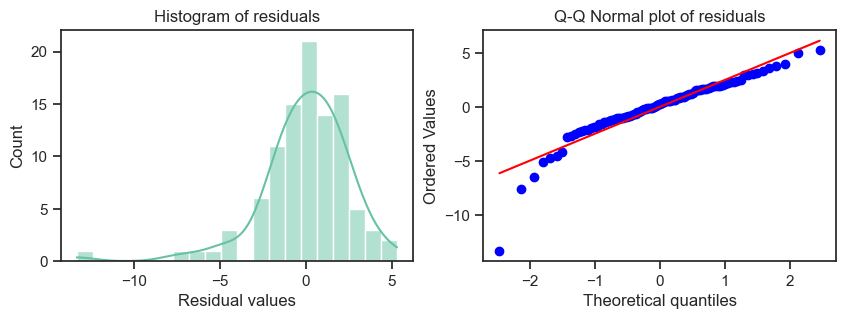

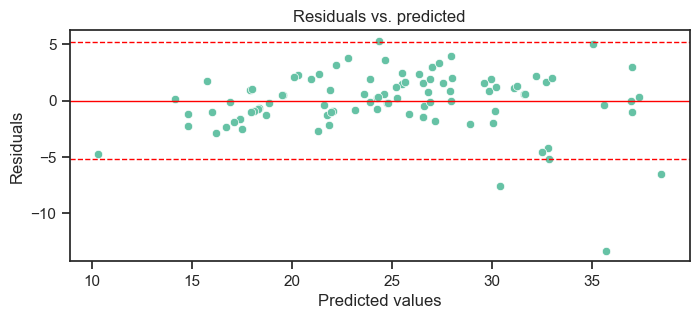

In [45]:
def compute_metrics(y_true, y_predicted):
    ## Compute the usual metrics
    mse = sklm.mean_squared_error(y_true, y_predicted)
    rmse = sqrt(mse)
    mae = sklm.median_absolute_error(y_true, y_predicted)
    return mse, rmse, mae

def print_metrics(df_test, model, label_col='city_mpg'):   
    df_test['predicted'] = model.predict(df_test)
    mse, rmse, mae = compute_metrics(df_test.loc[:,label_col],df_test.loc[:,'predicted'])   
    print('MSE  = {0:6.3f}'.format(mse))
    print('RMSE = {0:6.3f}'.format(rmse))
    print('MAE  = {0:6.3f}'.format(mae))    


def residual_plot(df):
    plt.rc('font', size=12)
    fig, ax = plt.subplots(figsize=(8, 3), ) 
    RMSE = np.std(df.resids)
    sns.scatterplot(x='predicted', y='resids', data=df, ax=ax);
    plt.axhline(0.0, color='red', linewidth=1.0);
    plt.axhline(2.0*RMSE, color='red', linestyle='dashed', linewidth=1.0);
    plt.axhline(-2.0*RMSE, color='red', linestyle='dashed', linewidth=1.0);
    plt.title('Residuals vs. predicted');
    plt.xlabel('Predicted values');
    plt.ylabel('Residuals');
    plt.show()

def plot_resid_dist(df):
    resids = df.loc[:,'resids']
    plt.rc('font', size=12)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3));
    ## Plot a histogram
    sns.histplot(x=resids, bins=20, kde=True, ax=ax[0]);
    ax[0].set_title('Histogram of residuals');
    ax[0].set_xlabel('Residual values');
    ## Plot the Q-Q Normal plot
    ss.probplot(resids, plot = ax[1]);
    ax[1].set_title('Q-Q Normal plot of residuals');
    plt.show();    

def compute_residuals(df, model, label_col='city_mpg'):
    df['predicted'] = model.predict(df)
    df['resids'] = np.subtract(df.loc[:,'predicted'], df.loc[:,label_col]) 
    return df
    
print_metrics(auto_data_test, base_model)
auto_data_train = compute_residuals(auto_data_train, base_model)
plot_resid_dist(auto_data_train)
residual_plot(auto_data_train)

Overall the residuals look well-behaved. The distribution of the residuals is a bit skewed toward the negative, but not too seriously. Further, the residuals are approximately homoskedastic. 

### Testing the Box-Cox transform   

We might be able to improve these results using the **Box-Cox transform** of the label column `city_mpg`. The goal of the Box-Cox transform is to transform the distribution of the label values (dependent variable) to be closer to Normal. The residuals of the resulting model should also be closer to Normally distributed, a key assumption of the least-squares method.       

The Box-Cox transform is a **power law transform**, related to the **logarithmic transform**. The Box-Cox transform finds a power, $\lambda$, that creates a transform of the values to be as close to Normal as possible. The Box-Cox algorithm is defined by the following relations:   
$$
x^{(\lambda)}_i = 
\begin{cases}
      \frac{x^{\lambda}_i - 1}{\lambda},\ if \lambda \ne 0 \\
      ln(x_i),\ if \lambda = 0
\end{cases}  
$$

Note that in this formulation $\lambda=0$ is the logarithm since $log(1) = 0$. Any values $0 \gt \lambda \lt 1$ are roots of the values $x$. For example, for square root we get $\lambda = log(0.5) = -0.69$.  For values $1 \gt \lambda \gt \inf$ the variable is raised to a power. As another example, if the power is squared, then $\lambda = log(2.0) = 0.69$, same absolute value of $\lambda$ with the opposite sign. 

The code in the cell below applies the Box-Cox transform to the label column and prints the power, $\lambda$, computed. The code uses the [boxcox](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html) function from scipy.stats. The data sample split again into training and test subsets. Execute this code. 

In [46]:
## Apply Box-Cox transform to the label and print the power used   
auto_data.loc[:,'city_mpg'], power = ss.boxcox(auto_data.loc[:,'city_mpg'])
print('The power of the Box-Cox transform = {0:6.3f}'.format(power))

## Split the data using the transformed label values
## Create a mask and use it to split the data into a train and test set   
nr.seed(654566)
mask = nr.choice(auto_data.index, size = 100, replace=False)
auto_data_train = auto_data.iloc[mask,:].reset_index()
auto_data_test = auto_data.drop(mask, axis=0).reset_index() 

The power of the Box-Cox transform =  0.054


/var/folders/2x/j2yg_98j10n2xd364kzb8nvm0000gn/T/ipykernel_6402/3689816520.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[3.30864222 3.30864222 3.19102321 3.46656107 3.12774646 3.19102321
 3.19102321 3.19102321 3.06105224 3.41610511 3.41610511 3.30864222
 3.30864222 3.25122428 2.99053779 2.99053779 2.9157238  4.27889578
 4.01879112 4.01879112 3.98636798 3.77243301 3.46656107 3.77243301
 3.77243301 3.77243301 3.46656107 3.46656107 3.19102321 4.33023974
 3.77243301 4.01879112 3.733009   3.733009   3.733009   3.733009
 3.60680219 3.60680219 3.60680219 3.60680219 3.46656107 3.51506593
 3.46656107 3.46656107 2.9157238  2.9157238  2.75076483 3.733009
 3.77243301 3.77243301 3.77243301 3.77243301 3.56176879 3.56176879
 3.56176879 3.56176879 3.95310495 3.56176879 3.19102321 3.77243301
 3.3635294  3.3635294  3.3635294  3.3635294  2.99053779 2.99053779
 2.83603363 2.83603363 3.19102321 3.98636798 3.77243301 3.77243301
 

To compute a new OLS model, execute the code below and examine the results.   

MSE  =  0.010
RMSE =  0.098
MAE  =  0.057
                            OLS Regression Results                            
Dep. Variable:               city_mpg   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     151.5
Date:                Tue, 05 Nov 2024   Prob (F-statistic):           3.66e-49
Time:                        12:56:31   Log-Likelihood:                 103.96
No. Observations:                 100   AIC:                            -189.9
Df Residuals:                      91   BIC:                            -166.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

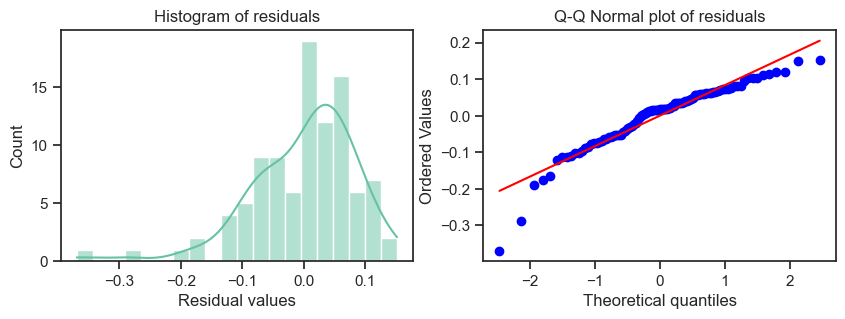

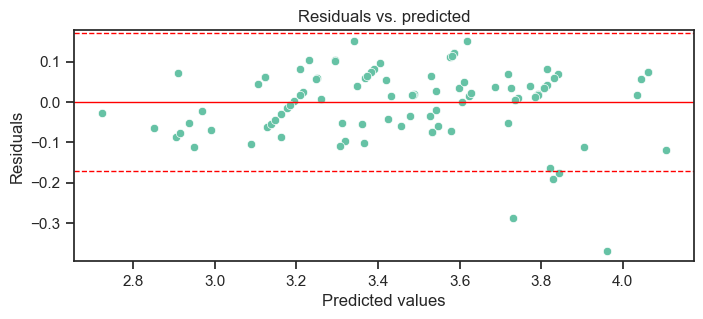

In [47]:
## Compute the model using the transformed label and display the summary
base_model = smf.ols(formula, data=auto_data_train).fit()

## Display diagnostics using the training data
print_metrics(auto_data_test, base_model)   
print(base_model.summary())
auto_data_train = compute_residuals(auto_data_train, base_model)
plot_resid_dist(auto_data_train)
residual_plot(auto_data_train)

The value of $\lambda$ is very close to 0, indicating the Box-Cox transform is close to a logarithm. As a result, the values of adjusted $R^2$, the F-statistic and the log-likelihood have all improved. The distribution of the residuals has indeed changed, but is still noticeably non-Normal in the tail. Given the improved least-squares fit, we will continue with the transformed label.   

This model is still significantly over-fit. We employ regularization methods to address this situation. We will use the metrics displayed as a basis of comparison with regularized models.  

> **Note:** No one regularization method works in all cases. In the running example you will see deviations from ideal behavior. Do not be surprised if not all methods improve the models. Further, do not generalize the behavior you observe in the exercises to other models. The effectiveness of regularization method is problem and model dependent.  

## Apply l2 regularization

Now, you will apply **l2 regularization** to constrain the model parameter values. Constraining the model parameters over-fitting of the model. This method is also known as **Ridge Regression**. 

But, how does this work? l2 regularization applies a **penalty** proportional to the **l2** or **Euclidean norm** of the model weights to the loss function. For linear regression using squared error as the metric, the total **loss function** is the sum of the squared error and the regularization term. The total loss function can then be written as follows:  

$$J(\beta) = ||A \beta - b||^2 + \alpha^2 ||\beta||^2$$

Where the penalty term on the model coefficients, $\beta_i$, based on the Euclidean norm:

$$|| \beta||^2 =  \big(\beta_1^2 + \beta_2^2 + \ldots + \beta_n^2 \big)^{\frac{1}{2}} = \alpha \Big( \sum_{i=1}^n \beta_i^2 \Big)^{\frac{1}{2}}$$

We call $||\beta||^2$ the **l2 norm** of the coefficients, since we raise the weights of each coefficient to the power of 2, sum the squares and then raise the sum to the power of $\frac{1}{2}$. 

You can think of this penalty as constraining the 12 or Euclidean norm of the model weight vector. The value of $\alpha$ determines how much the norm of the coefficient vector constrains the solution. You can see a geometric interpretation of the l2 penalty constraint in the figure below.  

<img src="images/L2.jpg" alt="Drawing" style="width:750px; height:400px"/>
<center>Geometric view of l2 regularization

Notice that for a constant value of the l2 norm, the values of the model parameters $B_1$ and $B_2$ are related. The Euclidean or l2 norm of the coefficients is shown as the dotted circle. The constant value of the l2 norm is a constant value of the penalty. Along this circle the coefficients change in relation to each other to maintain a constant l2 norm. For example, if $B_1$ is maximized then $B_2 \sim 0$, or vice versa. It is important to note that l2 regularization is a **soft constraint**. Coefficients are driven close to, but likely not exactly to, zero.    

### Review of Eigenvalue Decomposition

**Eigenvalues** are characteristic roots or characteristic values of a linear system of equations. The **eigenvalue-eigenvector** decomposition is a factorization of the a matrix. 

Let's start with a **square matrix**, $A$:

$$A = 
\begin{bmatrix}
   a_{11}  & a_{12} & \dots & a_{1n} \\
    a_{21}  & a_{22} & \dots & a_{2n} \\
    \vdots &\vdots &\vdots & \vdots \\
    a_{n1} & a_{n2} &  \dots & a_{nn}
\end{bmatrix}$$

Next define a vector, $x$: 

$$x = 
\begin{bmatrix}
   x_{1}\\
    x_{2}\\
    \vdots\\
    x_{n}
\end{bmatrix}$$

Then an **eigenvalue** of the matrix $A$ has the property: 

$$A x = \lambda x$$

Or,   

$$
\begin{bmatrix}
   a_{11}  & a_{12} & \dots & a_{1n} \\
    a_{21}  & a_{22} & \dots & a_{2n} \\
    \vdots &\vdots &\vdots & \vdots \\
    a_{n1} & a_{n2} &  \dots & a_{nn}
\end{bmatrix}  
\begin{bmatrix}
   x_{1}\\
    x_{2}\\
    \vdots\\
    x_{n}
\end{bmatrix} 
= 
\lambda 
\begin{bmatrix}
   x_{1}\\
    x_{2}\\
    \vdots\\
    x_{n}
\end{bmatrix}
$$



To see that the eigenvalue, $\lambda$, is a root of the matrix, $A$ we can rearrange the above as follows:   

\begin{align}
Ax - \lambda x &= 0 \\
(A - I \lambda) x &= 0
\end{align}

Where, $I$ is the **identity matrix** of 1 on the diagonal and 0 elsewhere. These relationships can be written as follows:  

$$
\begin{bmatrix}
   a_{11} - \lambda  & a_{12} & \dots & a_{1n} \\
    a_{21}  & a_{22} - \lambda  & \dots & a_{2n} \\
    \vdots &\vdots &\vdots & \vdots \\
    a_{n1} & a_{n2} &  \dots & a_{nn} - \lambda 
\end{bmatrix}  
\begin{bmatrix}
   x_{1}\\
    x_{2}\\
    \vdots\\
    x_{n}
\end{bmatrix} 
= 
0
$$


The foregoing show that the eigenvalue, $\lambda$, is a root of the matrix, $A$.

For an $n\ x\ n$ matrix, $A$, there are $n$ eigenvalues or roots. These can be found by solving the following equation, using the determinant:  

$$det(A - x) = 0$$

You can find more information on the determinant in this [article](https://en.wikipedia.org/wiki/Determinant).

### 2.1.3 Eigenvalues and the Normal Equations

Let's start by examining the **normal equation** formulation of the linear regression problem. The goal is to compute a vector of **model coefficients** or weights which minimize the mean squared residuals, given a vector of data $x$ and a **model matrix** $A$. We can write our model as:

$$x = A b$$

To solve this problem we would ideally like to compute:

$$b = A^{-1}x$$

The commonly used normal equation form can help with this problem:

$$b = (A^TA)^{-1}A^Tx$$

Now, $A^TA$ is a symmetric $m x m$ covariance matrix, where $m$ is the number of model coefficients. This is a significant reduction in size when compared to $A$. 

Now, we can perform eigenvalue-eigenvector decomposition of $A^TA$:

$$A^TA = Q \Lambda Q^{-1}$$

Where,
$Q = $ unitary matrix of orthonormal **eigenvectors**, and
$\Lambda =$ diagonal matrix of **eigenvalues**. The eigenvalue matrix is diagonal:  

$$\Lambda = 
\begin{bmatrix}
    \lambda_1  & 0 & 0 & \dots & 0 \\
    0  & \lambda_2 & 0 & \dots & 0 \\
    \vdots &\vdots &\vdots & & \vdots \\
    0 & 0 & 0 & \dots & \lambda_n
\end{bmatrix}$$


Since Q is unitary (unit norm), the inverse of $A^TA$ is easily computed:

$$(A^TA)^{-1} = Q \Lambda^{-1} Q^{-1}$$

Where,
$$\Lambda^{-1} = 
\begin{bmatrix}
    \frac{1}{\lambda_1}  & 0 & 0 & \dots & 0 \\
    0  & \frac{1}{\lambda_2} & 0 & \dots & 0 \\
    \vdots &\vdots &\vdots & & \vdots \\
    0 & 0 & 0 & \dots & \frac{1}{\lambda_n}
\end{bmatrix}$$
and $\lambda_i$ is the ith eigenvalue. 

But, **$A^TA$ can still be rank deficient!** By rank deficient we mean that there are fewer non-zero eigenvalues of $A^TA$ than the dimension, $n$. Even if the ith eigenvalue is close to zero, $\frac{1}{\lambda_i}$ becomes very large and destabilizes the inverse. 

The basic idea of $l_2$ regularization, Tikhonov regularization, or ridge regression is to stabilize the inverse eigenvalue matrix,$\Lambda$, by **adding a small bias term**, $\alpha$, to each of the eigenvalues. We can write this operation in matrix notation as follows. We start with a modified form of the normal equations (also know as the **L2 or Euclidean norm** minimization problem):

$$min [\parallel A \cdot x - b \parallel + \parallel \alpha^2 \cdot I \parallel]\\  or \\
b = (A^TA + \alpha^2 \cdot I)^{-1}A^Tx$$

In this way, the inverse values of small eigenvalues do not blow up when we compute the inverse. You can see this by writing out the $\Lambda^+$ matrix with the bias term.

$$\Lambda_{Tikhonov}^+  = \begin{bmatrix}
    \frac{1}{\lambda_1 + \alpha^2}  & 0 & 0 & \dots & 0 \\
    0  & \frac{1}{\lambda_2 + \alpha^2} & 0 & \dots & 0 \\
    \vdots &\vdots &\vdots & & \vdots \\
    0 & 0 & 0 & \dots & \frac{1}{\lambda_m + \alpha^2}
\end{bmatrix}$$

Adding this bias term ensures there are no non-zero eigenvalues, and that the inverse of $A^TA$ exists. You can also see that added the bias term adds a 'ridge' along the diagonal of the eigenvalue matrix, giving this method one of its names. 

### The Bayesian Interpretation

Another way to view l2 regularization is using a Bayesian formulation of the problem. Let's start with the posterior distribution of the weight vector $W$ given the features $X$ and labels $Y$. Using Bayes rule we can write this posterior distribution as:

$$p( W\ |\ \{X,Y\} ) = \frac{p(W)\ p(\{X,Y\}\  |\  W\ )}{p( \{X,Y\})}$$

where,

$p(W) = $ the prior distribution of $W$.   
$p(\{X,Y\}\  |\  W\ ) = $ the likelihood of $\{X,Y\}$ given $W$.

We want the **maximum a posteriori** or **MAP** of the weights, $W$. Taking the log of both sides:

$$max_W log \big( p( W\ |\ \{X,Y\} ) \big) \propto max_W\ \Big[ log \big( p(W) \big)\  + log \big( p(\{X,Y\}\  |\  W\ ) \big) \Big]\\
= max_W \Big[ log\big(prior(W)\big) + log \big( likelihood(\{X,Y\}\  |\  W\ ) \big) \Big]$$

For a Gaussian process with l2 loss and l2 regularization we formulate the problem:

$$max_W log \big( p( W\ |\ \{X,Y\} ) \big) = max_W \Big[\frac{1}{n} \sum_{i=1}^n (f_W(x_i) - y_i)^2 + \lambda || W ||^2 \big) \Big]$$  

where,   
$\frac{1}{n} \sum_{i=1}^n (f_W(x_i) - y_i)^2 = $ the likelihood.    
$\lambda || W ||^2 = $ the prior acting as a regularization penalty. 


So how are we to interpret this prior? It is useful to view the prior as constraining the norm of the weight vector close to zero. In other words, we think of the weights as **shrinking** toward zero. Thus, the shrinkage process prevents the weights from reaching extreme values. 

### An example    

How can we use the eigenvalue decomposition of the covariance matrix to better understand how stable a linear model is? One way to summarize stability is to compute the **condition number**, which is the ratio of the largest to the smallest eigenvalue:   

$$condition\ number = \frac{largest\ eigenvalue}{smallest\ eigenvalue}$$   

A linear model with a covariance matrix having a large condition number is unstable and the model coefficients will be poorly determined. In other words, when the condition number is large, we can expect high variance and poor generalization. As a rule of thumb, the condition number of a **well-posed** linear model should be less than about 100. Otherwise, we say the model is **ill-posed**.    

> **Exercise 24-1:**  You will now compute the covariance matrix for the model specified above and evaluate its eigenvalues.     
> 1. Construct the design (model) matrix using the training data subset. You can do this with the [patsy.dematrix](https://patsy.readthedocs.io/en/latest/API-reference.html) function.      
> 2. Use [numpy.transpose](https://numpy.org/devdocs/reference/generated/numpy.transpose.html) and [numpy.matmul](https://numpy.org/doc/stable/reference/generated/numpy.matmul.html) functions to compute the covariance matrix of the design matrix. Make sure you normalize by dividing by the dimension of the covariance matrix!     
> 3. Compute the [numpy.linalg.eigvals](https://numpy.org/devdocs/reference/generated/numpy.linalg.eigvals.html) function to compute the eigenvalues. Save the real part of these complex numbers using [numpy.real](https://numpy.org/devdocs/reference/generated/numpy.real.html) and print the result.   
> 4. Compute and print the condition number.   

In [48]:
# Construct the design matrix using the training data subset
# Exclude the outcome variable 'city_mpg' from the formula
formula = 'C(fuel_type) + C(aspiration) + C(drive_wheels) + horsepower + compression_ratio + curb_weight + engine_size'
design_matrix = patsy.dmatrix(formula, data=auto_data_train)

covariance_matrix = np.matmul(design_matrix.T, design_matrix) / design_matrix.shape[1]

# Calculate the eigenvalues of the covariance matrix
eigenvalues = np.linalg.eigvals(covariance_matrix)

#  Compute the condition number (ratio of the largest to smallest eigenvalue)
condition_number = np.max(eigenvalues) / np.min(eigenvalues) # I get same result using built in function

print(eigenvalues)
print('\nThe condition number = {0:6.1f}'.format(condition_number))

[3.70911220e+01 2.55747061e+01 1.34015188e+01 2.86512261e+00
 2.15704737e+00 1.90740312e+00 9.00067856e-03 2.25414542e-01
 6.76394925e-01]

The condition number = 4120.9


> What does this condition number tell you about the stability of the coefficient estimates for this model? Is this consistent with what you learned from the model summary?   

> **Answer:**  > **Answer:**   One of the eigenvalues is nearly zero (0.009), leading to a division by near zero when calculating the condition number, resulting in a very large condition number of ~4120. This situation indicates that the covariance matrix is singular, which suggests that the design matrix has perfect multicollinearity—some variables are linearly dependent on others.
>
> Yes the two are consistent as the model shows a high condition number of 64.2^2=~4120 (squared for comparison given the different methodology in calculation) and has a high R^2 but many insignificant predictors. A high condition number indicates that the matrix is close to singular, meaning that small changes in the input data can cause large changes in the model's coefficients. This instability arises from multicollinearity, where two or more predictor variables are highly correlated. 

### Example of ridge regression   

When L2 regularization is applied to regression the resulting algorithm is often referred to as **ridge regression**. For this algorithm, the regularization parameter, $\alpha$, must be selected. For a given problem, there are limited theory-based options to find the best value of $\alpha$, Therefore, one typically resorts to a **hyperparameter** search. 

There are several possible approaches to hyperparameter search. An error metric, such as MSE or MAE is used to determine the optimal value.    

The simplest approach is to search of grid (or line) of regularly spaced hyperparameter values. At each gird point the model performance metric is computed. The best model is considered the one with the best metric. We will use this simpler approach here.       

An alternative is to randomly sample the space of hyperparameter values. This later approach is more efficient.     

> **Exercise 24-2:** You will now perform a search to find a best regularization hyperparameter by the following steps:      
> 1. Complete the code in the `regularized_coefs` function to compute a regularized OLS model using the value of alpha and L1_wt using [statsmodels.regression.linear_model.OLS.fit_regularized](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.fit_regularized.html). For each value of alpha searched, this model will be computed and evaluated.      
> 2. In the space provided below, provide code to create an array of alpha values from 0.0 to 0.005 in steps of 0.00005.  
> 3. Using the `regularized_coefs` define code for the search over the values of $\alpha$.   
> 4. Execute the code and examine the results.  

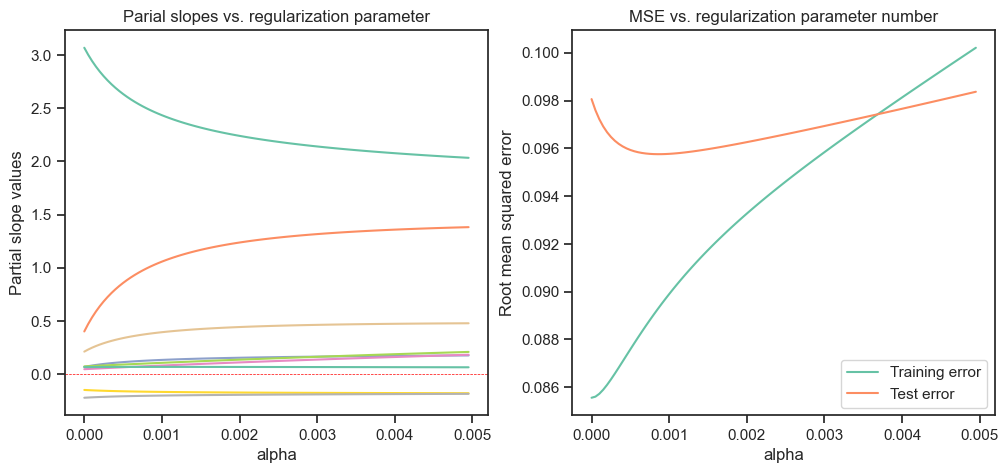

In [49]:
formula = 'city_mpg ~ C(fuel_type) + C(aspiration) + C(drive_wheels) + horsepower + compression_ratio + curb_weight + engine_size'

def regularized_coefs(df_train, df_test, alphas, L1_wt=0.0, n_coefs=8,
                      formula = formula, label='city_mpg'):
    '''Function that computes a linear model for each value of the regualarization 
    parameter alpha and returns an array of the coefficient values. The L1_wt 
    determines the trade-off between L1 and L2 regualarization'''
    coefs = np.zeros((len(alphas),n_coefs + 1))
    MSE_train = []
    MSE_test = []
    for i,alpha in enumerate(alphas):
        ## First compute the training MSE
        #### Complete the line of code below
        temp_mod = sm.OLS.from_formula(formula, df_train).fit_regularized(alpha=alpha, L1_wt=L1_wt)
        
        ## Save the coefficient values   
        coefs[i,:] = temp_mod.params

        ## Compute and save the training RMSE
        MSE_train.append(sqrt(np.mean(np.square(df_train[label] - temp_mod.predict(df_train)))))
        ## Then compute the test RMSE
        MSE_test.append(sqrt(np.mean(np.square(df_test[label] - temp_mod.predict(df_test)))))
        
    return coefs, MSE_train, MSE_test


def plot_coefs(coefs, alphas, MSE_train, MSE_test, ylim=None, \
               title='MSE vs. regularization parameter number',\
               ylab='Root mean squared error', location='lower right'):
    fig, ax = plt.subplots(1,2, figsize=(12, 5)) # define axis
    for i in range(coefs.shape[1]): # Iterate over coefficients
        ax[0].plot(alphas, coefs[:,i])
    ax[0].axhline(0.0, color='red', linestyle='--', linewidth=0.5)
    ax[0].set_ylabel('Partial slope values')
    ax[0].set_xlabel('alpha')
    ax[0].set_title('Parial slopes vs. regularization parameter')
    if ylim is not None: ax[0].set_ylim(ylim)
    
    ax[1].plot(alphas, MSE_train, label='Training error')
    ax[1].plot(alphas, MSE_test, label='Test error')
    ax[1].set_ylabel(ylab)
    ax[1].set_xlabel('alpha')
    ax[1].set_title(title)
    plt.legend(loc=location)
    plt.show()

np.random.seed(12856)
### You code goes here
alphas = np.arange(0.0, 0.005, 0.00005)
Betas, MSE_train, MSE_test = regularized_coefs(auto_data_train, auto_data_test, alphas, L1_wt=0.0, n_coefs=8)

plot_coefs(Betas, alphas, MSE_train, MSE_test) 

> Examine these plots and answer these questions:     
> 1. Notice how the training error increases in value with increasing regularization hyperparameter. This is expected, since as the coefficient values of the model are forced toward 0, the training bias increases. Notice however, the behavior of the MSE for the test data. To single digit precision, approximately at which value is the test MSE minimized?         
> 2. The parameters with the largest magnitude are intercept and gas fuel. Describe how these parameters change with $\alpha$.

> **Answers:**       
> 1.  The test MSE appears to be minimized at approximately α=0.001. This is where the test error curve is at its lowest point before it starts increasing again, indicating the best trade-off between bias and variance.
> 2.   As α increases, the coefficients for the parameters, including the intercept and gas fuel, gradually decrease in magnitude. This is because higher regularization penalizes larger coefficients, effectively shrinking them towards zero. The intercept remains relatively stable compared to other coefficients, but it still shows a slight reduction. The coefficient for gas fuel, initially large, reduces significantly as α increases, indicating its reduced impact on the model as regularization strength increases.

> **Exercise 24-3:** Now you will evaluate the L2 regularized model using a value of $\alpha = 0.001$. This is value of $\alpha$ provides only mild regularization and will provide a basis for comparison with subsequent models.       
> 1. Compute a regularized OLS model using the training data and the [statsmodels.regression.linear_model.OLS.fit_regularized](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.fit_regularized.html) method.     
> 2. Print the coefficient comparison between the base model and the regularized model.   
> 3. Compute and print the MSE, RMSE and MAE for the model, using the test data.   
> 4. Compute the residuals, using the test data, and display distribution plots and the plot of residuals vs. predicted values.  

                        Compare model     Model
Intercept                    3.067088  2.433344
C(fuel_type)[T.gas]          0.401878  1.057893
C(aspiration)[T.turbo]       0.068874  0.134576
C(drive_wheels)[T.fwd]       0.047243  0.081631
C(drive_wheels)[T.rwd]       0.073563  0.107223
horsepower                  -0.147665 -0.166061
compression_ratio            0.212431  0.394921
curb_weight                 -0.220941 -0.200378
engine_size                  0.066912  0.068818

Magnitude of base model = 3.11  Without intercept = 0.54
Magnitude of new model = 2.70  Without intercept = 1.18


MSE  =  0.009
RMSE =  0.096
MAE  =  0.049


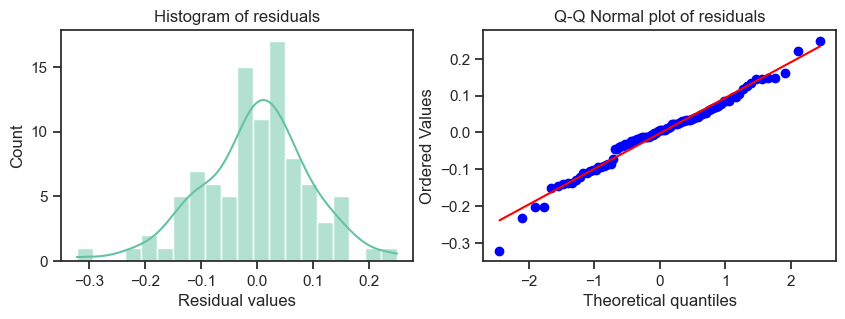

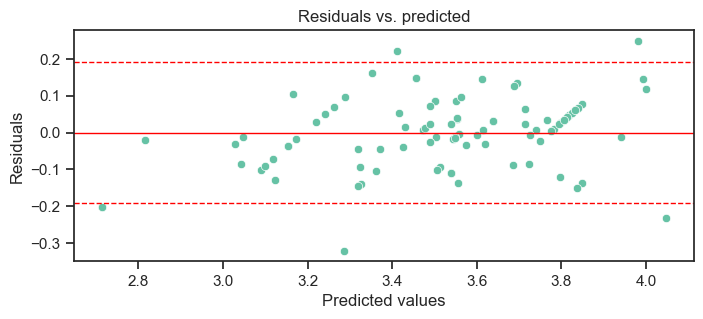

In [50]:
def print_coefficient_comparision(mod, compare_mod):
    df = pd.DataFrame(compare_mod.params)  
    df = pd.concat([df, pd.Series(mod.params, index=df.index)], axis=1)
    df.columns = ['Compare model','Model']                
    print(df)
    comp_mag = np.linalg.norm(df.loc[:,'Compare model'])
    mag = np.linalg.norm(df.loc[:,'Model'])
    df.drop('Intercept', axis=0, inplace=True)
    comp_mag_nointercept = np.linalg.norm(df.loc[:,'Compare model'])
    mag_nointercept = np.linalg.norm(df.loc[:,'Model'])

    print('\nMagnitude of base model = {0:4.2f}  Without intercept = {1:4.2f}'.format(comp_mag, comp_mag_nointercept))
    print('Magnitude of new model = {0:4.2f}  Without intercept = {1:4.2f}'.format(mag, mag_nointercept))

### You code goes here

L2_model = smf.ols(formula, data=auto_data_train).fit_regularized(alpha=0.001, L1_wt=0.0)

## Display results   
print_coefficient_comparision(L2_model, base_model)
print('\n')
print_metrics(auto_data_test, L2_model, label_col='city_mpg')
auto_data_test = compute_residuals(auto_data_test, L2_model)
plot_resid_dist(auto_data_test)
residual_plot(auto_data_test)

> Examine these results and answer these questions:   
> 1. Examine the comparison of the model coefficients. What does the change in the norm of the parameter vector tell you about the regularization?        
> 2. Compare the RMSE and MAE of the regularized model to the same metrics for the unregularized model. In terms of which of these metrics is the regularized model better and worse? Keeping in mind that the model is a constrained least squares fit, do the results make sense?   
> 3. How does the distribution of the residuals compare to those of the unregularized models in terms of changes of skewness and the outlier?
> . Do the residuals still appear approximately homoskedastic? 
> **End of exercise.**  

> **Answers:**     
> 1.   Comparison of Model Coefficients: Regularization generally reduces the magnitude of the model coefficients, as it imposes a penalty on their size. This decrease in the norm of the parameter vector implies that the model is less sensitive to individual features, which can help reduce overfitting and make the model more generalizable. Essentially, the regularized model focuses more on the important patterns rather than fitting noise in the data. Interestingly the magnitude without intercept is relatively higher for the new model, perhaps because it wants to retain important features and reduce the noise from intercept.
> 2.   RMSE and MAE Comparison: The RMSE and MAE of the regularized model are slightly lower than those of the unregularized model. RMSE will generally improve due to reduced variance, which aligns with the purpose of regularization to prevent extreme parameter values and lower overfitting. As the model is a constrained least squares fit, it makes sense given L2 regularization typically reduces model complexity, helping to avoid overfitting, which yields the lower RMSE and MAE.
>
> MAE is generally less sensitive to large errors than RMSE. With regularization, the MAE may not reduce as much as RMSE does, since regularization mainly limits the extreme parameter values but has less effect on consistent, small errors, but nonetheless a reduction in MAE means improved predictability which is desired here.
> 
> 3.  Ideally, residuals should be symmetrically distributed around zero, reflecting an unbiased prediction. The spread of residuals appears to be relatively even, and there are no extreme outliers anymore, which suggests that the residuals are approximately homoskedastic, with no apparent pattern of changing variance across predicted values.

> **Exercise 24-4:** You will now compare the condition number of the regularized covariance matrix to the unregularized covariance matrix you computed earlier.     
> 1. Add a matrix with the value of the square root of the optimal $alpha$ value estimated along the diagonal (0 elsewhere) to the covariance matrix you computed in Exercise 24-2. Use [numpy.diag]() to instantiate the diagonal matrix.    
> 2. Compute and display the eigenvalues of the regularized covariance matrix.  
> 3. Compute and display the condition number of the regularized covariance matrix. 

In [51]:
import numpy as np

# Optimal alpha value
alpha = 0.001

# Step 1: Add regularization to the diagonal
# Create a diagonal matrix with the square root of alpha along the diagonal
reg_matrix = np.diag([np.sqrt(alpha)] * covariance_matrix.shape[0])

# Regularized covariance matrix
reg_cov_matrix = covariance_matrix + reg_matrix

# Step 2: Compute eigenvalues of the regularized covariance matrix
reg_eigenvalues = np.linalg.eigvalsh(reg_cov_matrix)  # Use eigvalsh for symmetric matrices
print("Eigenvalues of the regularized covariance matrix:")
print(reg_eigenvalues)

# Step 3: Compute the condition number of the regularized covariance matrix
reg_condition_number = np.linalg.cond(reg_cov_matrix)
print("\nCondition number of the regularized covariance matrix:")
print(reg_condition_number)

Eigenvalues of the regularized covariance matrix:
[ 0.04062346  0.25703732  0.7080177   1.93902589  2.18867015  2.89674539
 13.43314154 25.60632886 37.12274478]

Condition number of the regularized covariance matrix:
913.8253904389059


> Compare the condition numbers you have computed for the regularized and unregularized condition number. Has regularization made a significant difference? Does the regularized model still appear to have an undesirably large condition number?  

> **Answer:**  The regularization has made a significant difference as the condition number has decreased from 4120 to 913 and this is improved in terms of numerical stability. However, the regularized model still has a condition number that is too large, which ideally should be lower than 30-40.         

## Apply l1 regularizaton

Regularization can be performed using norms other than l2. The **l1 regularizaton** or **Lasso**  method limits the sum of the absolute values of the model coefficients. The l1 norm is sometime know as the **Manhattan norm**, since distance are measured as if you were traveling on a rectangular grid of streets. This is in contrast to the l2 norm that measures distance 'as the crow flies'. 

We can compute the l1 norm of the model coefficients as follows:

$$||\beta||^1 = \big( |\beta_1| + |\beta_2| + \ldots + |\beta_n| \big) = \Big( \sum_{i=1}^n |\beta_i| \Big)^1$$

where $|\beta_i|$ is the absolute value of $\beta_i$. 

Notice that to compute the l1 norm, we raise the sum of the absolute values to the first power.

As with l2 regularization, for l1 regularization, a penalty term is multiplied by the l1 norm of the model coefficients. A penalty multiplier, $\alpha$, determines how much the norm of the coefficient vector constrains values of the weights. The complete loss function is the sum of the squared errors plus the penalty term which becomes: 

$$J(\beta) = ||A \beta - b||^2 + \alpha^2 ||\beta||^1$$

You can see a geometric interpretation of the l1 norm penalty in the figure below.  

<img src="images/L1.jpg" alt="Drawing" style="width:700px; height:400px"/>
<center> Geometric view of L1 regularization

The l1 norm is constrained by the sum of the absolute values of the coefficients. This fact means that values of one parameter highly constrain another parameter. The dotted line in the figure above looks as though someone has pulled a rope or lasso around pegs on the axes. This behavior leads the name lasso for l1 regularization.  

Notice that in the figure above that if $B_1 = 0$ then $B_2$ has a value at the limit, or vice versa. In other words, using a l1 norm constraint forces some weight values to zero to allow other coefficients to take non-zero values. Thus, you can think of the l1 norm constraint **knocking out** some weights free the model altogether. In contrast to l2 regularization, l1 regularization does drive some coefficients to exactly zero.

> **Exercise 24-5:** Continuing with the running example you will now apply L1 regularization to the model.    
> 1. Create an array with values of $\alpha$ from 0.0 to 0.05 in steps of 0.005.   
> 2. Using the hyperparameter search function you created for exercise 24-2, compute the model performance metrics for each value of $\alpha$ and with `L1_wt` set to 1.0; all weight on L1 regularization. 
> 3. Plot the results using the `plot_coefs` function. It will help your understanding to set `ylim=[-0.3,0.3]` for the `plot_coefs` function. 
> 4. Execute your code.  

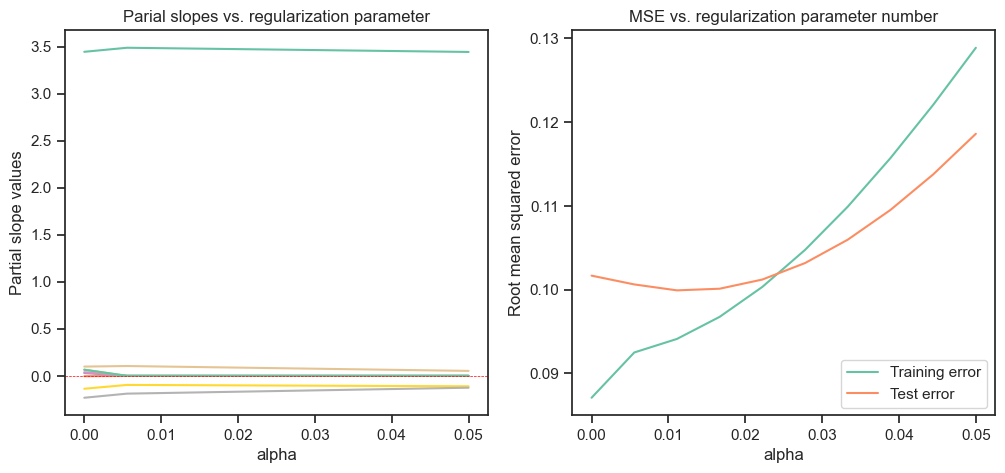

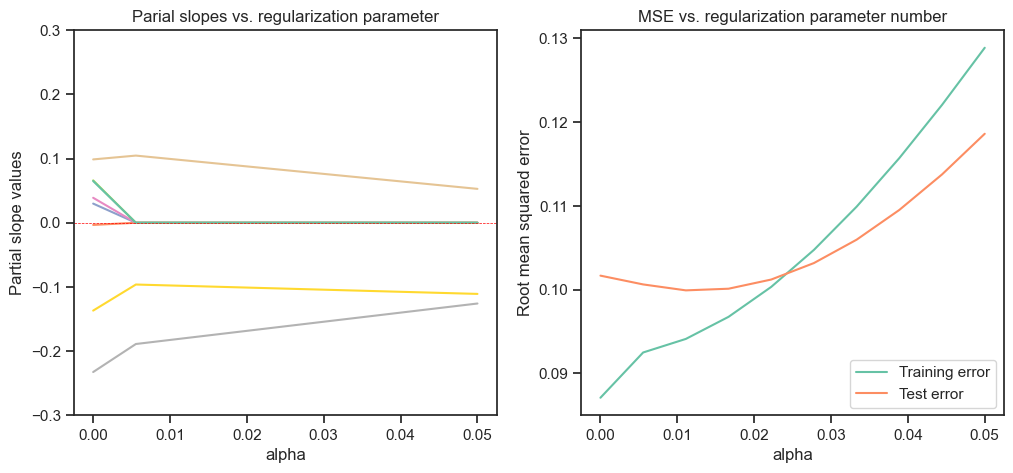

In [52]:
alphas = np.linspace(0.0, 0.05, 10) 
Betas, MSE_train, MSE_test = regularized_coefs(auto_data_train, auto_data_test, alphas, L1_wt=1.0, n_coefs=8)

plot_coefs(Betas, alphas, MSE_train, MSE_test)

plot_coefs(Betas, alphas, MSE_train, MSE_test, ylim=[-0.3,0.3])


> Examine these plots and answer these questions.    
> 1. Examine the change in parameter values with increasing $\alpha$. What evidence do you see that the L1 regularization is working as expected?    
> 2. Notice how the training error increases with increasing regularization hyperparameter. This is expected, since as the coefficient values of the model are forced toward 0, the training bias increases. Notice the behavior of the MSE for the test data. Where is the minimum? What does this tell you about the bias-variance trade-off?              

> **Answers:**      
>1. As α increases, the parameter values (partial slopes) show a tendency to converge toward zero. This is especially visible in the plot on the left where many of the lines approach the horizontal axis as α grows. This pattern is characteristic of L1 regularization (Lasso), which tends to force some coefficients to become exactly zero, effectively reducing the number of active features in the model. The behavior indicates that L1 regularization is working as expected by applying a penalty that encourages sparsity, reducing the influence of less significant features.
>2. As the regularization parameter alpha increases, the training error also increases. This is expected, as stronger regularization reduces model complexity and results in higher training bias. In the plot, you can see that the training error increases fairly stablely, while the test error initially decreases and reaches a minimum around a small positive alpha = 0.02. This should indicate an optimal point where the balance between bias and variance is achieved—where the model is not too simple (underfitting) nor too complex (overfitting). Beyond this point, increasing alpha further leads to increased bias, which might explain why the test error starts leveling off. This demonstrates the bias-variance trade-off, where moderate regularization can improve generalization by reducing overfitting.   

> **Exercise 24-6:** Now you will evaluate the L1 regularized model using the optimal a value $\alpha$ where there is a minimum in the test error curve.      
> 1. Compute a regularized OLS model using the training data and your estimate of the optimal value of $\alpha = 0.015and `L1_wt=1.0`.     
> 2. Compute and print the MSE, RMSE and MAE for the model, using the test data.   
> 3. Compute the residuals, using the test data, and display distribution plots and the plot of residuals vs. predicted values.   
> 4. Print the model coefficients. These coefficients are the `params` attribute of the model object.   



MSE  =  0.010
RMSE =  0.100
MAE  =  0.044


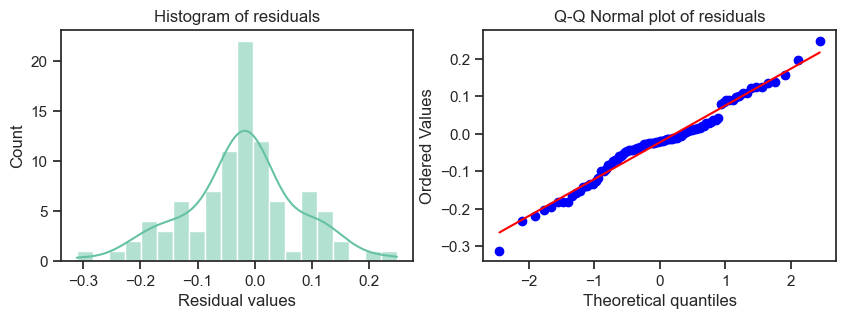

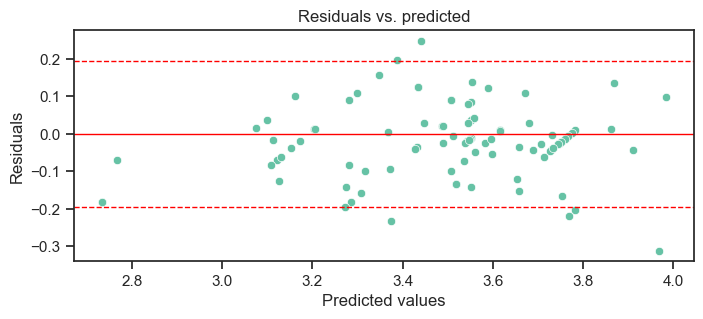


Model Coefficients:
Intercept                 3.478953
C(fuel_type)[T.gas]       0.000000
C(aspiration)[T.turbo]    0.000000
C(drive_wheels)[T.fwd]    0.000000
C(drive_wheels)[T.rwd]    0.000000
horsepower               -0.099379
compression_ratio         0.093641
curb_weight              -0.175554
engine_size               0.000000
dtype: float64


In [53]:
formula = 'city_mpg ~ C(fuel_type) + C(aspiration) + C(drive_wheels) + horsepower + compression_ratio + curb_weight + engine_size'

L1_model = smf.ols(formula, data=auto_data_train).fit_regularized(alpha=0.015, L1_wt=1.0)

## Display results   
print('\n')
print_metrics(auto_data_test, L1_model, label_col='city_mpg')
auto_data_test = compute_residuals(auto_data_test, L1_model)
plot_resid_dist(auto_data_test)
residual_plot(auto_data_test)

print("\nModel Coefficients:")
print(L1_model.params)

> Examine these results and answer these questions.   
> 1. Examine the comparison of the model coefficients. What does the change in the norm of the parameter vector tell you about the regularization?    
> 2. Examine the model coefficients, noticing that some are 0.0 as expected with L1 regularization. What does this tell you about the usefulness of some of the model features?     
> 3. Compare the RMSE and MAE of the regularized model to the same metrics for the unregularized model. In terms of which of these metrics is the regularized model better and worse and is this outcome expected?    
> 4. How does the distribution of the residuals compare to those of the unregularized models in terms of changes of skewness, kurtosis and the outlier?

> **Answers:**    
> 1. The L1 regularization has reduced the norm of the parameter vector by setting some coefficients to exactly zero (e.g., fuel_type[T.gas], aspiration[T.turbo], engine_size). This behavior indicates that L1 regularization is working as expected, enforcing sparsity by selectively eliminating features with lower importance. The reduction in the norm (sum of the absolute values of coefficients) suggests that the model is simplified, as some features are effectively removed from the model.
>    
> 2. The fact that several coefficients are exactly zero means that the model has identified these features as having little to no contribution to predicting the target variable (city_mpg). This is useful because it suggests that certain features, such as fuel_type[T.gas], aspiration[T.turbo], and engine_size, may be redundant or irrelevant in this context. This feature selection property of L1 regularization can improve interpretability and reduce model complexity.
>     
> 3. The RMSE is very slightly higher at 0.100 vs 0.098 but the MAE is slightly lower at 0.044 vs 0.057. This slight increase in RMSE suggests a minor increase in bias, which is typical when regularization is applied. The regularization aims to improve the generalizability of the model, even if it slightly increases bias on the training or test data so this is expected. The Mean Absolute Error is slightly lower for the regularized model (0.044) compared to the unregularized model (0.057). This indicates that the regularized model performs better in terms of absolute error, meaning that, on average, the regularized model's predictions are closer to the actual values.
>    
> 4. The residual distribution for the regularized model appears symmetric as the histogram of residuals suggests minimal skewness. The Q-Q plot aligns well with the theoretical quantiles, indicating that the residuals follow a normal distribution reasonably well. There are few extreme residual values, indicating that regularization has mitigated the influence of outliers.
Overall, the regularized model's residuals seem better behaved, with reduced skewness and kurtosis, suggesting improved robustness compared to an unregularized model. 

## Elastic Net Regularization    

We have now examined a bit of theory and examples of L2 and L1 regularization. We can compare the characteristics of these methods as follows:  

- L2 regularization works well for **colinear features**    
   - Down-weights colinear features   
   - But soft constraint so poor model selection 

- L1 regularization provides **good model selection** by hard constraint    
   - But poor selection for colinear features     

But, we do not always have to choose between soft constraint of L2 and hard constraint of L1. The **elastic net regularization** combines the behavior of both methods. The loss function for elastic net is expressed:         

$$min \Big[ \parallel A \cdot x - b \parallel +\ \lambda\ \alpha^2 \parallel b\parallel^1 +\ (1- \lambda)\ \alpha^2 \parallel b\parallel^2 \Big]$$        

This model has two hyperparameters:    
- $\lambda$ weights L1 vs. L2 regularization.      
- $\alpha$ sets strength of regularization.   

Tuning this model, requires a 2-dimensional hyperparameter search. This search can be done on a grid or by random sampling, as was discussed previously.           

> **Exercise 24-7:**  Continuing with the running example you will now apply elastic net regularization to the model.    
> 1. Create an array with values of $\alpha$ from 0.0 to 0.03 in steps of 0.0005.   
> 2. Using the hyperparameter search function you created for exercise 24-2 compute the model performance metrics for each value of $\alpha$ and with `L1_wt` set to 0.5. 
> 3. Plot the results using the `plot_coefs` function. It will help your understanding to set `ylim=[-0.5,1.0]` for the `plot_coefs` function.    
> 4. Execute your code.  

**Note:** In this case, we equal weight L2 and L1 regularization in order to simplify the hyperparameter search.
 Performance could possibly improved if a 2-hyperparameter search was performed.       

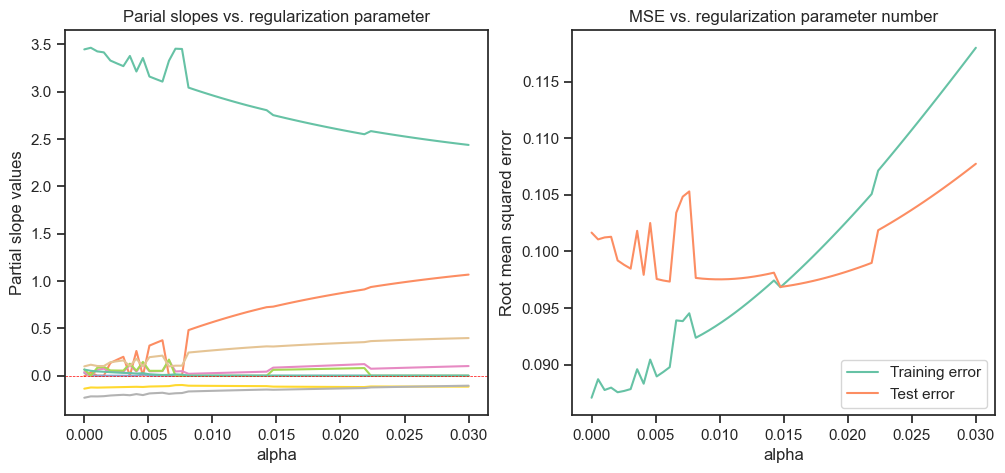

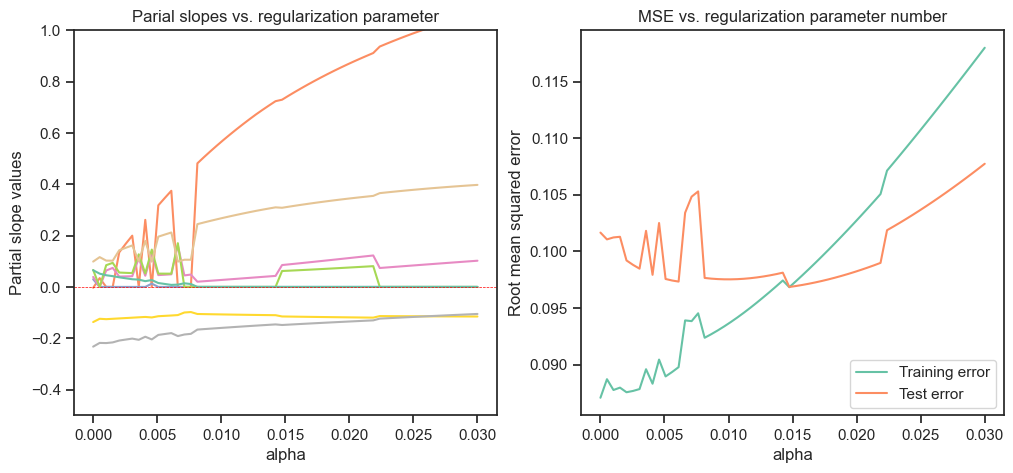

In [54]:
### You code goes here
alphas = np.linspace(0.0, 0.03, 60)
Betas, MSE_train, MSE_test = regularized_coefs(auto_data_train, auto_data_test, alphas, L1_wt=0.5, n_coefs=8)

plot_coefs(Betas, alphas, MSE_train, MSE_test)

plot_coefs(Betas, alphas, MSE_train, MSE_test, ylim=[-0.5,1.0])


> One again, the curve of training error does not have a well defined minimum, except at $\alpha = 0$. 
> 1. How are the parameter values changing as the regularization parameter increases, in particular coefficients driven to 0?    
> 2. Is there any well defined minimum for the test error?     
> 3. Based on this behavior, do you expect that elastic net regularization to improve model generalization?      

> **Answers:**     
> 1. As the regularization parameter α increases, the partial slope values (coefficients) either stablizes or converge towards zero, with several coefficients being driven to exactly zero. This behavior reflects the effect of Elastic Net regularization, which combines both L1 and L2 regularization, with L1 shrinking some to exactly 0 while L2 smoothes other coefficients without completely removing them, reducing the impact of multicollinearity.
> 2. The test error curve shows a decrease initially as α increases, indicating that regularization is helping reduce overfitting. However, there isn’t a clear, well-defined minimum in the test error curve. Instead, the test error oscillates as α increases, which may be due to the balance between L1 and L2 regularization or the noise in the dataset. The oscillation suggests that the model may be sensitive to the regularization parameter in this range, or it may indicate that other factors (such as a different balance between L1 and L2) could improve stability.
> 3.  Yes, Elastic Net regularization is likely to improve model generalization. The observed behavior, with initial decreases in test error as α increases, suggests that Elastic Net is successfully balancing bias and variance by both removing irrelevant features (L1) and reducing multicollinearity (L2).

> **Exercise 24-8:** Now you will evaluate the elastic net regularized model using an arbitrary value of $\alpha$.      
> 1. Compute a regularized OLS model using the training data an estimate of the optimal value of $\alpha = 0.015$ and `L1_wt=0.5`, putting equal weight on L2 and L1.     
> 2. Compute and print the MSE, RMSE and MAE for the model, using the test data.   
> 3. Compute the residuals, using the test data, and display distribution plots and the plot of residuals vs. predicted values.   
> 4. Print the model coefficients. These coefficients are the `params` attribute of the model object.    



MSE  =  0.009
RMSE =  0.097
MAE  =  0.053


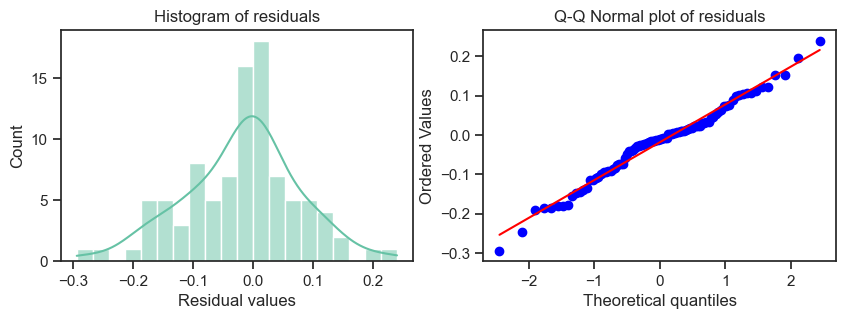

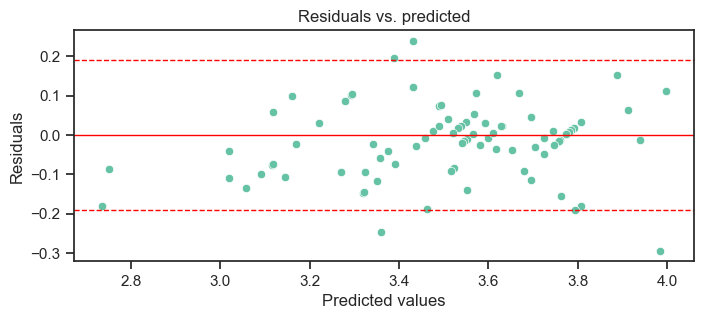


Model Coefficients:
Intercept                 2.743111
C(fuel_type)[T.gas]       0.737224
C(aspiration)[T.turbo]    0.000000
C(drive_wheels)[T.fwd]    0.086447
C(drive_wheels)[T.rwd]    0.062573
horsepower               -0.115304
compression_ratio         0.310392
curb_weight              -0.147664
engine_size               0.000000
dtype: float64


In [55]:
formula = 'city_mpg ~ C(fuel_type) + C(aspiration) + C(drive_wheels) + horsepower + compression_ratio + curb_weight + engine_size'

Enet_model = smf.ols(formula, data=auto_data_train).fit_regularized(alpha=0.015, L1_wt=0.5)

## Display results   
print('\n')
print_metrics(auto_data_test, Enet_model, label_col='city_mpg')
auto_data_test = compute_residuals(auto_data_test, Enet_model)
plot_resid_dist(auto_data_test)
residual_plot(auto_data_test)

print("\nModel Coefficients:")
print(Enet_model.params)

> Examine these results and answer these questions.   
> 1. Compare the RMSE and MAE of the regularized model to the same metrics for the unregularized model. In terms of which of these metrics is the regularized model better and worse and is this behavior expected? 
> 2. Do the residuals still appear approximately Normal and homoscedastic?    
> 3. Examine the model coefficients? Are any of the coefficients 0? Is this behavior expected from the soft constraint of L2 regularization or the hard constraint of L1 regularization.        

> **Answers:**    
> 1.  The RMSE of the regularized model (0.097) is slightly lower than the unregularized model (0.098), indicating a small improvement in predictive accuracy on the test data.
The MAE is also slightly lower in the regularized model (0.053 compared to the unregularized model's 0.057).  This slight improvement in both RMSE and MAE suggests that the Elastic Net regularization has improved the model's performance by achieving a better bias-variance balance. The reduction in error metrics is expected as Elastic Net combines L1 and L2 regularization, which can reduce overfitting by shrinking and eliminating less important coefficients.        
> 2. Yes, there is no clear patterns, outliers, and the QQ-plot is behaving well and approximately normal.             
> 3. Yes, 2 of them are 0 and this is expected from the L1 hard component of zeroing out less important features, and is a combination of the L1 and L2 seen prior (We saw even more components go to 0 in pure L1).           

## Extended Example: GLM with ElasticNet     

Let's try an end-to-end example. In previous chapters we worked with an HR dataset with the objective of classifying employees who are likely to leave a company. We will now apply ElasticNet regularization to a generalized linear model (GLM) to this problem.       

We will start by loading and preparing the dataset. Execute the code in the cell below.  

In [56]:
hr_data = pd.read_csv('HR_comma_sep.csv')
for col in ['satisfaction_level','average_montly_hours','last_evaluation', 'number_project', 'time_spend_company']:
    hr_data.loc[:,col] = (hr_data.loc[:,col] - np.mean(hr_data.loc[:,col]))/np.std(hr_data.loc[:,col])
## Create a mask and use it to split the data into a train and test set  
frac = 0.6
nr.seed(665)
mask = nr.choice(hr_data.index, size = int(frac * hr_data.shape[0]), replace=False)
hr_train = hr_data.iloc[mask,:]
hr_test = hr_data.drop(mask, axis=0)         
hr_train.columns

/var/folders/2x/j2yg_98j10n2xd364kzb8nvm0000gn/T/ipykernel_6402/1209265937.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.88203988  1.22042276  1.4206573  ... -1.16236823  1.58084493
 -0.86201642]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  hr_data.loc[:,col] = (hr_data.loc[:,col] - np.mean(hr_data.loc[:,col]))/np.std(hr_data.loc[:,col])
/var/folders/2x/j2yg_98j10n2xd364kzb8nvm0000gn/T/ipykernel_6402/1209265937.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.46286291  0.97111292  2.59376348 ... -1.46286291  1.7824382
 -1.46286291]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  hr_data.loc[:,col] = (hr_data.loc[:,col] - np.mean(hr_data.loc[:,col]))/np.std(hr_data.loc[:,col])
/var/folders/2x/j2yg_98j10n2xd364kzb8nvm0000gn/T/ipykernel_6402/120

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'sales', 'salary'],
      dtype='object')

There are quite a few columns in this dataset. We use most of these columns as independent variables for our GLM model. The code in the cell below constructs the model and prints the summary. Execute this code. 

In [57]:
formula = 'left ~ satisfaction_level + average_montly_hours + last_evaluation + C(salary) + C(promotion_last_5years) +\
          C(Work_accident) + number_project + time_spend_company + C(promotion_last_5years) + C(sales)'
hr_glm = smf.glm(formula=formula, data=hr_train, family=sm.families.Binomial()).fit()
hr_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   left   No. Observations:                 8999
Model:                            GLM   Df Residuals:                     8980
Model Family:                Binomial   Df Model:                           18
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3875.5
Date:                Tue, 05 Nov 2024   Deviance:                       7751.0
Time:                        12:56:34   Pearson chi2:                 8.41e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2155
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -3.0056      0.187    -16.092      0.000      -3.372      -2.640
C(salary)[T.low]                  1.8725      0.161     11.614      0.000       1.556       2.188
C(salary)[T.medium]               1.3600      0.162      8.377      0.000       1.042       1.678
C(promotion_last_5years)[T.1]    -1.7924      0.352     -5.087      0.000      -2.483      -1.102
C(Work_accident)[T.1]            -1.5152      0.115    -13.151      0.000      -1.741      -1.289
C(sales)[T.RandD]                -0.1911      0.170     -1.127      0.260      -0.524       0.141
C(sales)[T.accounting]            0.2558      0.157      1.631      0.103      -0.052       0.563
C(sales)[T.hr]                    0.5550      0.153      3.617      0.000       0.254       0.856
C(sales)[T.management]           -0.2882      0.196     -1.467      0.142      -0.673       0.097
C(sales)[T.marketing]             0.2042      0.160      1.275      0.202      -0.110       0.518
C(sales)[T.product_mng]           0.1166      0.153      0.760      0.447      -0.184       0.417
C(sales)[T.sales]                 0.1790      0.115      1.563      0.118      -0.046       0.403
C(sales)[T.support]               0.2323      0.124      1.868      0.062      -0.011       0.476
C(sales)[T.technical]             0.2730      0.120      2.276      0.023       0.038       0.508
satisfaction_level               -1.0142      0.031    -32.375      0.000      -1.076      -0.953
average_montly_hours              0.2429      0.033      7.265      0.000       0.177       0.308
last_evaluation                   0.1215      0.033      3.655      0.000       0.056       0.187
number_project                   -0.3938      0.034    -11.481      0.000      -0.461      -0.327
time_spend_company                0.4223      0.029     14.323      0.000       0.364       0.480
=================================================================================================
"""

Examine the model summary. The deviance and Pearson $\chi^2$ indicate the model makes significant predictions. However, notice that the model is significantly overfit, with nearly all coefficients not being significant.      

To evaluate this model execute the code in the cell below.  

In [58]:
def display_metrics(hr_test, threshold):
    print('\n\nPrediction of leaving:')
    print(hr_test.loc[:5,'predicted'])
    
    print('\nConfusion Matrix')
    Confusion_Matrix = metrics.confusion_matrix(hr_test.loc[:,'left'], hr_test.loc[:,'predicted'])
    accuracy = metrics.accuracy_score(hr_test.loc[:,'left'], hr_test.loc[:,'predicted'])
    precision = metrics.precision_score(hr_test.loc[:,'left'], hr_test.loc[:,'predicted'])
    recall = metrics.recall_score(hr_test.loc[:,'left'], hr_test.loc[:,'predicted'])
    Confusion_Matrix = pd.DataFrame(Confusion_Matrix, index=['True Stay', 'True Leave'], columns = ['Predicted Stay', 'Predicted Leaving'])
    print(Confusion_Matrix)
    print(f"\nAccuracy = {round(accuracy, 3)}")
    print(f"Precision = {round(precision, 3)}")
    print(f"Recall = {round(recall, 3)}")

threshold = 0.4
hr_test.loc[:,'predicted_prob'] = hr_glm.predict(hr_test)
hr_test.loc[:,'predicted'] = np.where(hr_test.loc[:,'predicted_prob'] > threshold, 1, 0)
display_metrics(hr_test, threshold)



Prediction of leaving:
0    1
Name: predicted, dtype: int64

Confusion Matrix
            Predicted Stay  Predicted Leaving
True Stay             4063                533
True Leave             659                745

Accuracy = 0.801
Precision = 0.583
Recall = 0.531


We will use these performance metrics as a basis of comparison.     

Next, we will test a number of regularization parameter values. Execute the code in the cell below and examine the results.   

/opt/anaconda3/envs/tensorflow_env/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1464: UserWarning: Elastic net fitting did not converge
  warnings.warn("Elastic net fitting did not converge")


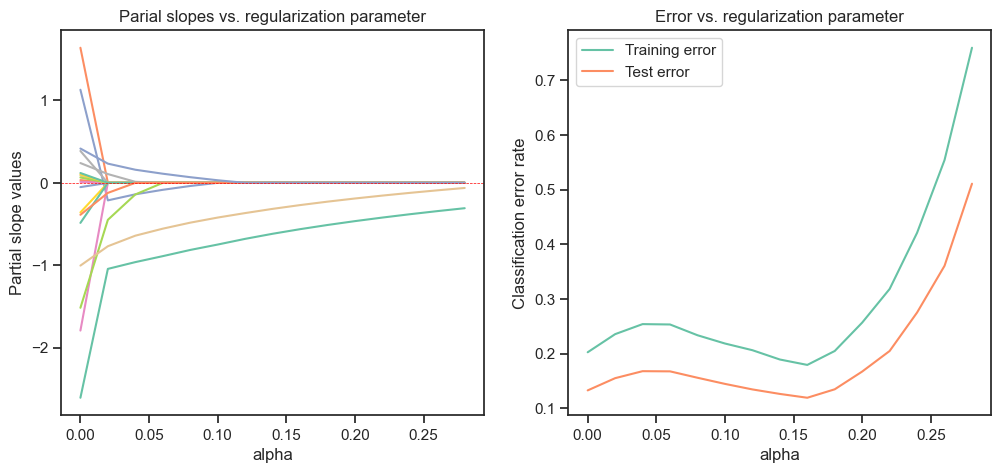

In [59]:
def regularized_coefs_glm(df_train, df_test, alphas, L1_wt=0.0, n_coefs=18,
                      formula = formula, label='left', threshold = 0.4):
    '''Function that computes a linear model for each value of the regualarization 
    parameter alpha and returns an array of the coefficient values. The L1_wt 
    determines the trade-off between L1 and L2 regualarization'''
    coefs = np.zeros((len(alphas),n_coefs + 1))
    err_train = []
    err_test = []
    for i,alpha in enumerate(alphas):
        ## First compute the training MSE
        #### Complete the line of code below
        temp_mod = smf.glm(formula, data=df_train, family=sm.families.Binomial()).fit_regularized(alpha=alpha,L1_wt=L1_wt)
        
        ## Save the model coefficeints
        coefs[i,:] = temp_mod.params
        ## Compute training error 
        err_train.append(np.sum(np.abs(df_train.loc[:,label] - np.where(temp_mod.predict(df_train) > threshold, 1, 0)))/float(len(hr_train)))
        ## Then compute the test error
        err_test.append(np.sum(np.abs(df_test.loc[:,label] - np.where(temp_mod.predict(df_test) > threshold, 1, 0)))/float(len(df_train)))        
    return coefs, err_train, err_test


alphas = np.arange(0.0, 0.3, step = 0.02)
Betas, err_train, err_test = regularized_coefs_glm(hr_train, hr_test, alphas, L1_wt=0.5, formula = formula)

plot_coefs(Betas, alphas, err_train, err_test, title='Error vs. regularization parameter',\
           ylab='Classification error rate', location='upper left')

The test classification error is minimized at the $\alpha=0.16$. Notice that at $\alpha=0.16$ only 7 of the original 19 model coefficients are nonzero.  

Finally, we can evaluate this model at the optimal value of $\alpha$. Execute the code in the cell bellow to construct and evaluate the regularized model. 

In [60]:
hr_glm_elastic = smf.glm(formula=formula, data=hr_train, family=sm.families.Binomial()).fit_regularized(alpha=0.16,L1_wt=0.5)

print_coefficient_comparision(hr_glm_elastic, hr_glm)

threshold = 0.4
hr_test.loc[:,'predicted_prob'] = hr_glm_elastic.predict(hr_test)
hr_test.loc[:,'predicted'] = np.where(hr_test.loc[:,'predicted_prob'] > threshold, 1, 0)
display_metrics(hr_test, threshold)

                               Compare model     Model
Intercept                          -3.005600 -0.562344
C(salary)[T.low]                    1.872465  0.000000
C(salary)[T.medium]                 1.360047  0.000000
C(promotion_last_5years)[T.1]      -1.792357  0.000000
C(Work_accident)[T.1]              -1.515249  0.000000
C(sales)[T.RandD]                  -0.191113  0.000000
C(sales)[T.accounting]              0.255755  0.000000
C(sales)[T.hr]                      0.554964  0.000000
C(sales)[T.management]             -0.288210  0.000000
C(sales)[T.marketing]               0.204210  0.000000
C(sales)[T.product_mng]             0.116597  0.000000
C(sales)[T.sales]                   0.178955  0.000000
C(sales)[T.support]                 0.232349  0.000000
C(sales)[T.technical]               0.272973  0.000000
satisfaction_level                 -1.014180 -0.270031
average_montly_hours                0.242898  0.000000
last_evaluation                     0.121468  0.000000
number_pro

Compare these results to the unregularized model. These metrics are somewhat improved over the unregularized model. This result is a bit unusual, but seem to arise from the fact that the unregularized model was so severely overfit. The regularization has improved the generalization, hence the better performance with the test dataset.         

## Summary

In this lab you have explored the basics of regularization. Regularization can prevent machine learning models from being overfit. Regularization is required to help machine learning models generalize when placed in production. Selection of regularization strength involves consideration of the bias-variance trade-off. 

L2 and l1 regularization constrain model coefficients to prevent overfitting. L2 regularization constrains model coefficients using a Euclidian norm. L2 regularization can drive some coefficients toward zero, usually not to zero. On the other hand, l1 regularization can drive model coefficients to zero.    

The elastic net algorithm provides weighted behavior between the L1 and L2 methods. 

#### Copyright 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024 Stephen F Elston. All rights reserved. 